## TensorFlow로 구현하기

### MNIST 받기

In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = tf.test.gpu_device_name()
print(device)



In [42]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

valid_size = 0.2
num_train = len(X_train)
indices = list(range(num_train))
np.random.seed(33)
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

X_valid, y_valid = X_train[valid_idx], y_train[valid_idx]
X_train, y_train = X_train[train_idx], y_train[train_idx]

X_train, X_valid, X_test = X_train/255, X_valid/255, X_test/255

print(f"X_train_shape: {X_train.shape}")  # X_train_shape: (60000, 28, 28)
print(f"y_train_shape: {y_train.shape}")  # y_train_shape: (60000,)
print(f"X_valid_shape: {X_valid.shape}")  # X_train_shape: (60000, 28, 28)
print(f"y_valid_shape: {y_valid.shape}")  # y_train_shape: (60000,)
print(f"X_test_shape: {X_test.shape}")  # X_test_shape: (10000, 28, 28)
print(f"y_test_shape: {y_test.shape}")  # y_test_shape: (10000,)

X_train_shape: (48000, 28, 28)
y_train_shape: (48000,)
X_valid_shape: (12000, 28, 28)
y_valid_shape: (12000,)
X_test_shape: (10000, 28, 28)
y_test_shape: (10000,)


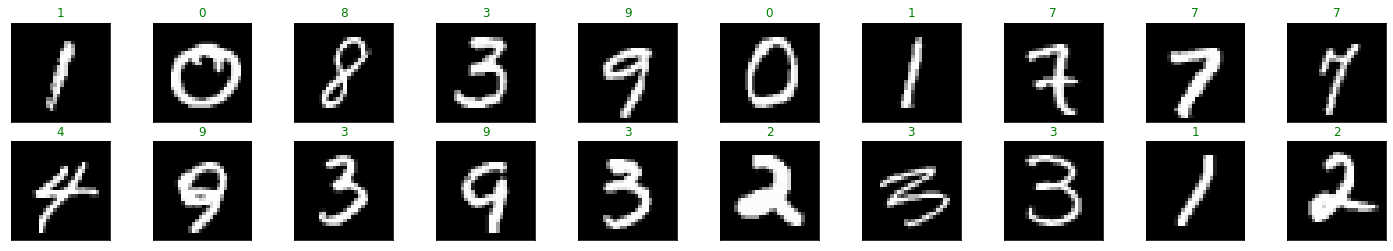

In [43]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    images, labels = X_train[idx], y_train[idx]
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels.item()))
    ax.set_title("{}".format(str(labels.item())),
                 color=("green"))

In [44]:
from tensorflow.keras import layers, models, activations

with tf.device(device):
    model = models.Sequential([
        layers.Conv2D(filters=28, kernel_size=(3, 3), strides=1, padding='same',
                    activation=activations.relu, input_shape=(28, 28, 1)),
        layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid'),
        layers.Conv2D(filters=56, kernel_size=(3, 3), strides=1,
                    padding='same', activation=activations.relu),
        layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid'),
      
        layers.AveragePooling2D(pool_size=(3, 3), padding='valid'),
        layers.Flatten(),
        
        layers.Dense(units=784, activation=activations.relu),
        layers.Dropout(rate=0.5),                      
        layers.Dense(units=392, activation=activations.relu),
        layers.Dropout(rate=0.5),
        layers.Dense(units=10, activation=activations.relu)
    ])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 28)        280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 56)        14168     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 56)         0         
 g2D)                                                            
                                                                 
 average_pooling2d_5 (Averag  (None, 2, 2, 56)         0         
 ePooling2D)                                                     
                                                      

In [45]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint('best_model.h5',             
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5, min_delta=0.005)

In [50]:
with tf.device('/device:GPU:0'):
    model.compile(optimizer='SGD', metrics=['accuracy'],
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    
    hist = model.fit(X_train, y_train, batch_size=20, epochs=100, callbacks=[checkpoint, earlystopping], validation_data=(X_valid, y_valid))

Epoch 1/100
2396/2400 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9873
Epoch 1: val_loss improved from 0.04149 to 0.04031, saving model to best_model.h5
2400/2400 [==============================] - 14s 6ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0403 - val_accuracy: 0.9870
Epoch 2/100
2391/2400 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9884
Epoch 2: val_loss did not improve from 0.04031
2400/2400 [==============================] - 13s 6ms/step - loss: 0.0375 - accuracy: 0.9884 - val_loss: 0.0427 - val_accuracy: 0.9868
Epoch 3/100
2392/2400 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9890
Epoch 3: val_loss did not improve from 0.04031
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.0435 - val_accuracy: 0.9875
Epoch 4/100
2399/2400 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9885
Epoch 4: val_loss improved

313/313 [==============================] - 1s 3ms/step - loss: 0.0274 - accuracy: 0.9902
[7 2 1 ... 4 5 6]
test loss:  0.027434328570961952
test accuracy: 0.9901999831199646
Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1131/1135)
Test Accuracy of     2: 99% (1025/1032)
Test Accuracy of     3: 99% (1002/1010)
Test Accuracy of     4: 99% (976/982)
Test Accuracy of     5: 98% (882/892)
Test Accuracy of     6: 99% (950/958)
Test Accuracy of     7: 99% (1022/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 97% (980/1009)


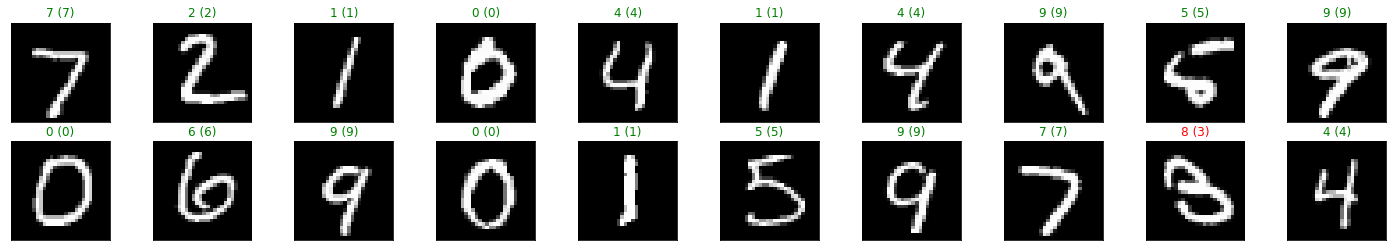

In [62]:
with tf.device('/device:GPU:0'):
    model.load_weights('best_model.h5')
    preds = model.predict(X_test)
    preds = np.array(list(map(lambda x: np.argmax(x), preds)))
    test_loss, test_acc = model.evaluate(X_test, y_test)

print( preds)
print('test loss: ', test_loss)
print('test accuracy:', test_acc)

class_correct = [0. for _ in range(10)]
class_total = [0. for _ in range(10)]
for i in range(len(preds)):
    if preds[i] == y_test[i]:
        class_correct[y_test[i]] += 1
    class_total[y_test[i]] += 1

for i in range(10):
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    images, labels = X_test[idx], y_test[idx]
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels.item()))
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels)),
                 color=("green" if preds[idx]==labels else "red"))